<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/growing_%CE%BCNCA_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## μNCA: Texture Generation with Ultra-Compact Neural Cellular Automata

*We strongly encourage using [this link](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/%CE%BCNCA_pytorch.ipynb) to open the notebook in Colaboratory.*

This notebook contains code to reproduce experiments and figures for ["μNCA: Texture Generation with Ultra-Compact Neural Cellular Automata"](https://arxiv.org/abs/2111.13545) article.

Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title imports, helpers 
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
!pip install -q --progress-bar off einops
from einops import rearrange
!pip install -q --progress-bar off pykeops[colab] geomloss
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from functools import partial

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

class LoopWriter(VideoWriter):
  def __init__(self, *a, fade_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.fade_len = int(fade_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.fade_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.fade_len:
      super().add(self._outro.pop(0))
  
  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()


torch.set_default_tensor_type('torch.cuda.FloatTensor')

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

!nvidia-smi -L

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.



GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c14ec042-691d-cb76-87fc-35c2022c7c4d)


In [83]:
def create_l2_loss(target_img):
  def loss_f(imgs):
    
    loss = torch.square(target_img - imgs).mean()
    return loss
  return loss_f


def create_l1_loss(target_img):
  def loss_f(imgs):
    loss = torch.abs(target_img - imgs).mean()
    return loss
  return loss_f


In [196]:
# μNCA 
side = torch.tensor([[0.0, 0.0,0.0], [2.0,-2.0,0.0], [0.0, 0.0,0.0]]) 
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]) 
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

# filters = [lap]*2+[sobel_x]*1+[sobel_x.T]*1  # 68 params
# filters = [lap]*2+[sobel_x]*2+[sobel_x.T]*2 # 150 params
# filters = [lap]*4+[sobel_x]*2+[sobel_x.T]*2  # 264 params
filters = [lap]*4+[sobel_x]*4+[sobel_x.T]*4  # 588 params

filters = torch.stack(filters)[:,None]
CHN = len(filters)

class CA(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.w = torch.nn.Parameter(torch.randn(CHN, 4*CHN+1, 1, 1)*1e-3)

  def to_rgb(self, x):
    return x[...,:3,:,:]  # +0.5

  def forward(self, x, update_rate=1.0):
    y = torch.nn.functional.pad(x, [1, 1, 1, 1], 'circular')
    y = torch.nn.functional.conv2d(y, filters, groups=y.shape[1])
    y = torch.cat([x, y], 1)
    y = y = torch.cat([y, y.abs()], 1)
    #y = torch.cat([y.relu(), -(-y).relu()], 1)
    w, b = self.w[:,:-1], self.w[:,-1,0,0]
    y = torch.nn.functional.conv2d(y, w, b)
    if update_rate<1.0:
      y *= (torch.rand(*y.shape)+update_rate).floor()

    # alive masking
    # x = torch.nn.functional.relu(x + .5) - .5
    # x[...,:3,:] = torch.nn.functional.relu(x[...,:3,:])
    
    return x+y, y
    
def seed_f(n, sz=128):
  s = torch.zeros(n, CHN, sz, sz) 
  s[:, :, int(sz/2), int(sz/2)] = 1.
  return s
  # return torch.rand(n, CHN, sz, sz)-0.5

ca = CA()
print('param count:', sum(p.numel() for p in ca.parameters()))

param count: 588


(128, 128, 3)


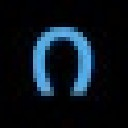

In [211]:
# target
url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/bubbly/bubbly_0101.jpg'
# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Mkhedruli_a.svg/640px-Mkhedruli_a.svg.png'
# url = 'https://imgur.com/z3phYQw'
# url = 'https://i.imgur.com/z3phYQw.png'
# url = 'https://i.imgur.com/GPZnuRE.jpg'
# url = 'http://2.bp.blogspot.com/-NY1r4-l0QS0/T9UD3Q-gHCI/AAAAAAAAB44/WfaoduQ6d4s/s1600/georgian-alphabet.jpg'
# url = 'https://i.imgur.com/RLpGgsO.jpg'
# url = 'https://i.imgur.com/vWwuGJj.jpg'
url = 'https://i.imgur.com/mkBadnc.jpg'

with torch.no_grad():
  style_img = imread(url, max_size=128)
  print(style_img.shape)
  # style_img.resize((128,104, 4))
  # texture_loss_f = create_ot_loss(to_nchw(style_img), ksize=3, leveln=2)
  texture_loss_f = create_l2_loss(torch.stack([to_nchw(style_img) for _ in range(4)]))
  # texture_loss_f = create_l1_loss(torch.tensor([style_img for _ in range(4)]))

imshow(style_img)

In [212]:
#@title setup training
ca = CA() 
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 4000], 0.3)
loss_log = []
with torch.no_grad():
  pool = seed_f(256)
!rm *.pt

rm: cannot remove '*.pt': No such file or directory


In [213]:
torch.backends.cudnn.benchmark = True

In [214]:
torch.tensor([style_img for _ in range(4)]).shape

torch.Size([4, 128, 128, 3])

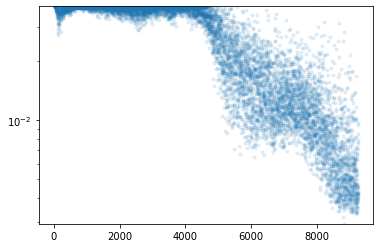

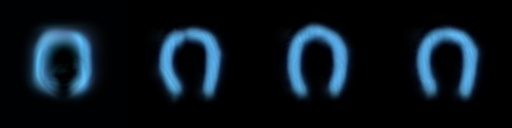

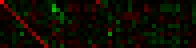

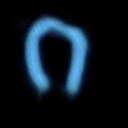

step_n: 9262  loss: 0.00896443985402584  lr: 8.999999999999999e-05

KeyboardInterrupt: ignored

In [236]:
#@title training loop {vertical-output: true}

def loss_f(x):
  loss = texture_loss_f(ca.to_rgb(x))
  # loss = texture_loss_f(ca.to_rgb(x))
  reg = (x-x.clamp(-1.0, 1.0)).square().sum()
  total_loss = loss + reg
  return total_loss, loss

best_long_loss = np.inf
best_long_step = 0

for i in range(10000):
  batch_idx = np.random.choice(len(pool), 4, replace=False)
  x = pool[batch_idx]
  if i%2 == 0:   
    x[:1] = seed_f(1)
  step_n = np.random.randint(64, 128)
  torch.autograd.set_grad_enabled(True)
  for _ in range(step_n):
    x, dx = ca(x)
    x.register_hook(partial(F.normalize, dim=[1,2,3]))
  total_loss, loss = loss_f(x)
  total_loss.backward()
  with torch.no_grad():
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      clear_output(True)

      min_loss = np.min(loss_log)
      pl.plot(loss_log, '.', alpha=0.1)
      if min_loss > 0.0:
        pl.yscale('log')
      pl.ylim(min_loss, loss_log[len(loss_log)//5])
      pl.show()
      imgs = ca.to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs))
      pl.show()
      p = ca.w.cpu()[:,:,0,0]
      vis = torch.stack([(-p).relu(), p.relu(), 0.0*p], -1)
      vis *= 1.0/vis.max()
      imshow(zoom(vis))
      pl.show()

      # show long-term behaviour
      x = seed_f(1)
      for _ in range(3000):
        x, _ = ca(x)
      img = ca.to_rgb(x)[0].permute(1, 2, 0).cpu()
      imshow(img)
      _, long_loss = loss_f(x.clip(-1, 1))
      if long_loss<best_long_loss and len(loss_log)-best_long_step > 100:
        torch.save(ca, 'ca_%05d.pt'%len(loss_log))
        best_long_loss = long_loss
        best_long_step = len(loss_log)

    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')

  """



  0%|          | 0/1000 [00:00<?, ?it/s]

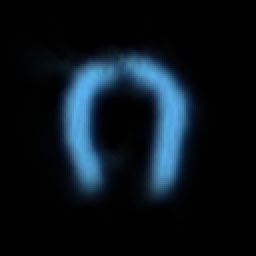

In [237]:
# μNCA pattern after 1000 steps 
with torch.no_grad():
  x = seed_f(1, 128)
  ca1 = torch.load('ca_%05d.pt'%best_long_step)
  for k in tnrange(1000, leave=False):
    x, _ = ca1(x)
  img = ca1.to_rgb(x)[0].permute(1, 2, 0).cpu()
  imshow(zoom(img, 2))

In [238]:
#@title μNCA dynamics evolution video {vertical-output: true}
with torch.no_grad():
  ca1 = torch.load('ca_%05d.pt'%best_long_step)
with LoopWriter('final_ca.mp4', fade_len=0.5) as vid, torch.no_grad():
  x = seed_f(1, 256)
  #x[:] = 0.0
  #x[:,:,100, 100] = 1.0
  for k in tnrange(200, leave=False):
    img = ca.to_rgb(x)[0].permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))
    step_n = int(min(2**(k/30), 8))
    for i in range(step_n):
      x, _ = ca1(x)
vid.show()

  0%|          | 0/200 [00:00<?, ?it/s]

In [239]:
# export 588-param to ShaderToy
if len(filters) == 12:
  w_scale = 500
  with torch.no_grad():
    w, b = ca1.w[:,:-1,0,0], ca1.w[:,-1,0,0]
    weight = (w.T*w_scale).round().cpu()
    bias = (b*w_scale).round().cpu()
  
  code = ['''
  vec4 update(float band, vec4 y[6]) {
    #define M mat4
    #define F(i,_a,_b) {M a=_a,b=_b; vec4 yi=y[i]; dx+=G(0)+G(1)+G(2)+G(3);}
    //#define G(i) yi[i]*((yi[i]>0.0)?a[i]:b[i])
    #define G(i) (yi[i]*a[i]+abs(yi[i])*b[i])
    vec4 dx;''']
  mat4_fmt = 'M(%s)'%','.join(['%d']*16)
  for i, band in enumerate(np.split(weight, 3, 1)):
    s = ' dx = vec4(%d,%d,%d,%d);'%tuple(bias[i*4:i*4+4])
    code.append('  '+('if (band == 0.) {', '} else if (band == 1.) {', '} else {')[i] + s)
    for j in range(CHN*2//4):
      a = mat4_fmt % tuple(band[j*4:][:4].ravel())
      b = mat4_fmt % tuple(band[j*4+CHN*2:][:4].ravel())
      code.append(f'    F({j}, {a}, {b});')
  code.append('''  }
    #undef M
    #undef F
    #undef G
    return dx/%.1f;
  }'''%w_scale)
  code = '\n'.join(code) 
  print(len(code))
  print(code)

2387

  vec4 update(float band, vec4 y[6]) {
    #define M mat4
    #define F(i,_a,_b) {M a=_a,b=_b; vec4 yi=y[i]; dx+=G(0)+G(1)+G(2)+G(3);}
    //#define G(i) yi[i]*((yi[i]>0.0)?a[i]:b[i])
    #define G(i) (yi[i]*a[i]+abs(yi[i])*b[i])
    vec4 dx;
  if (band == 0.) { dx = vec4(4,10,14,18);
    F(0, M(-94,-7,-8,-9,5,-54,-11,2,15,3,-35,-6,6,12,15,-49), M(-55,4,7,-1,14,-21,8,6,21,18,-5,5,2,-3,-7,14));
    F(1, M(-6,2,-1,13,7,5,5,5,6,-4,5,24,-4,5,7,-21), M(6,-3,2,0,-1,9,10,-11,5,3,3,3,-3,0,1,-20));
    F(2, M(-18,-10,-8,-13,0,3,6,-7,-2,7,8,-12,7,5,3,10), M(13,15,19,-22,-8,-2,-4,-12,-1,0,-6,-19,-1,-2,-3,2));
    F(3, M(14,11,9,3,15,57,74,18,0,-1,43,-6,1,-1,-4,35), M(3,-24,-30,2,-2,-6,-16,-8,-1,3,5,3,-2,-5,-4,5));
    F(4, M(4,7,14,-2,-5,-23,-28,-1,-4,-11,-9,2,-4,-14,-20,-7), M(2,14,15,-7,5,13,17,4,-6,15,19,-1,-3,9,11,10));
    F(5, M(2,0,0,-2,-4,-14,-19,-2,1,8,9,1,-1,-21,-27,-6), M(1,19,23,-2,-6,-6,-10,6,1,3,2,-6,3,-1,-1,-4));
  } else if (band == 1.) { dx = vec4(12,15,3,-6);
    F(0, M(-9